In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import cvutil as cvfinn
%matplotlib inline

## Image manipulation

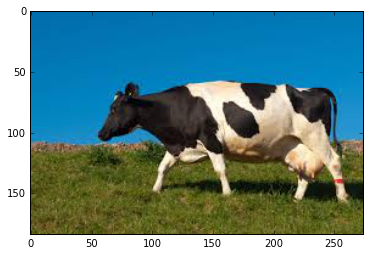

In [2]:
# read in an image and display it
img = cv2.imread("../images/cow3.jpg") 
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

### What is the type of img? hint: use the type() function

In [3]:
# put your code here


### You can select parts of an image using numpy slicing. 
Try to get a small image showing just the cow's front leg

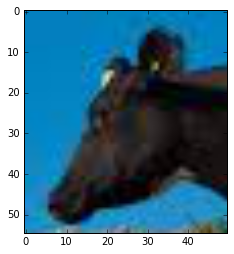

In [4]:
roi = rgb[55:110,50:100,:] #[ymin:ymax,xmin:xmax,channels]
plt.imshow(roi)

## Color spaces and tracking objects
The photos below contain the same set of object, photgraphed by different cameras and under different lighting conditions. Under each photo we plot the RGB and HSV histograms.

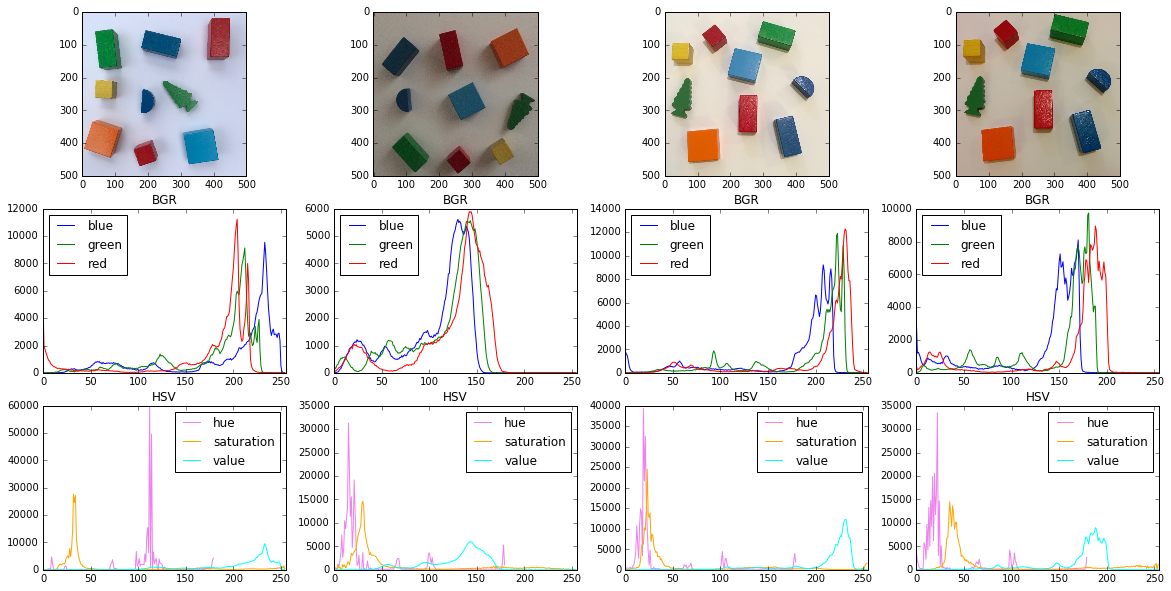

In [5]:
import os
image_names = sorted([os.path.join("../images/lighting",f) for f in os.listdir("../images/lighting")])
images = [cv2.imread(img) for img in image_names]
hsv_images = [cv2.cvtColor(img,cv2.COLOR_BGR2HSV) for img in images]
rgb_images = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in images]
fig,ax = plt.subplots(3,len(images),figsize=(20,10))
for indx,(img,hsv,rgb) in enumerate(zip(images,hsv_images,rgb_images)):
    ax[0,indx].imshow(rgb)
    cvfinn.plot_histogram(ax[1,indx],img,["blue","green","red"],"BGR")
    cvfinn.plot_histogram(ax[2,indx],hsv,["hue","saturation","value"],"HSV",legend_loc = "upper right")

Looking at these histograms, how might we seperate the blocks from the background? Will it be easier in RGB or HSV space?

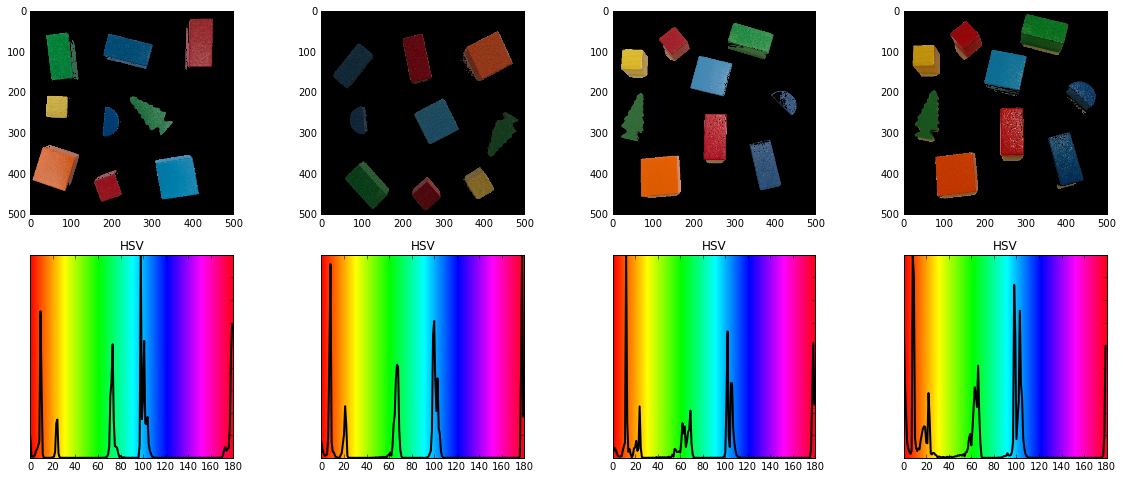

In [6]:
lower = np.array([0,100,5])
upper = np.array([180,256,256])
fig,ax = plt.subplots(2,len(images),figsize=(20,8))

for indx,(hsv,rgb) in enumerate(zip(hsv_images,rgb_images)):
    mask = cv2.inRange(hsv,lower,upper) # returns 255 if the pixel is in the specified range for all channels, 0 otherwise
    bmask = (mask > 0)
    pixels = hsv[:,:,0][mask > 0]
    res = cv2.bitwise_and(rgb,rgb, mask=mask)
    hsv_res = cv2.cvtColor(res,cv2.COLOR_RGB2HSV)
    ax[0,indx].imshow(res)
    cvfinn.plot_hsv_hist(ax[1,indx],pixels)



Try messing around with the range parameters to find each color of block as cleanly as possible

## Extracting colored objects

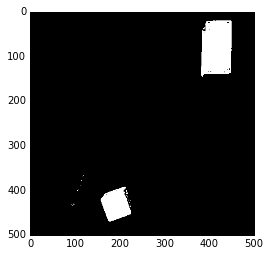

In [7]:
hsv = hsv_images[0]
lower = np.array([170,90,0])
upper = np.array([0,256,256])
img = cvfinn.hsvInRange(hsv,lower,upper)
plt.imshow(img,cmap="gray")

## Thresholding
Thresholding is the process of converting a grayscale image to a binary image.

Code for these examples adapted from http://docs.opencv.org/3.2.0/d7/d4d/tutorial_py_thresholding.html

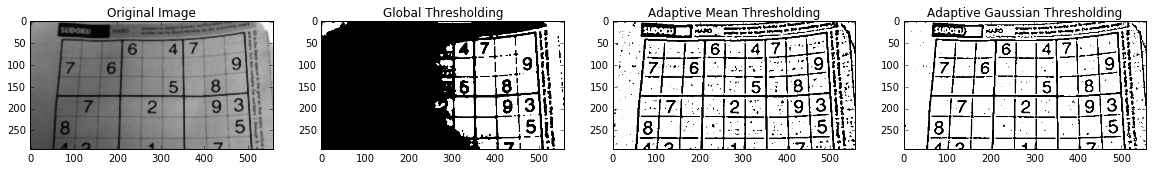

In [8]:
# Global vs local thresholding
img = cv2.imread('../images/sudoku.jpg',0)
img = cv2.medianBlur(img,5)
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding',
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
threshold_images = [img, th1, th2, th3]
fig, ax = plt.subplots(1,len(threshold_images),figsize=(20,5))
for indx,img in enumerate(threshold_images):
    ax[indx].imshow(img,cmap="gray")
    ax[indx].set_title(titles[indx])


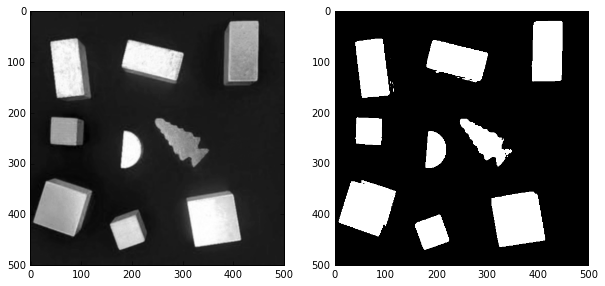

In [9]:
# Otsu's thresholding 
img = hsv_images[0][:,:,1] #extract just the saturation channel from our block picture.
img = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img,cmap="gray")
ax[1].imshow(th3,cmap="gray")

Compare what happens if with and without the GaussianBlur (and with different levels of bluring)

## Contours

In [10]:
images[0].shape

(500, 500, 3)

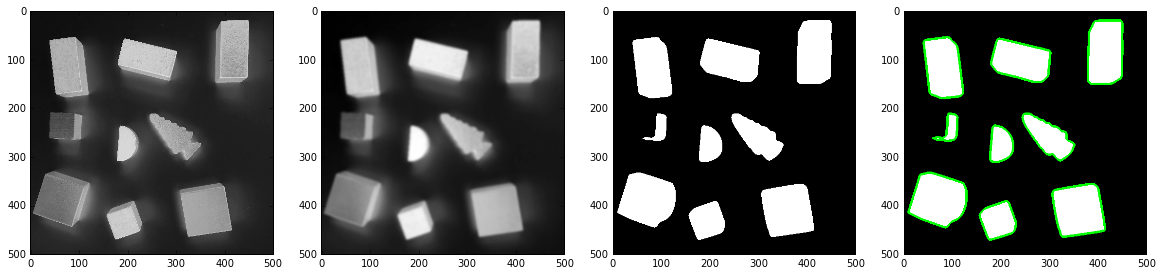

In [11]:
fig,ax = plt.subplots(1,4,figsize=(20,6))
im = cv2.bitwise_not(cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY))
im1 = cv2.GaussianBlur(im, (13, 13), 0)
ret,im2 = cv2.threshold(im1,100,255,cv2.THRESH_BINARY)

contour_im = im2
res,contours,hierarchy = cv2.findContours(contour_im.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #findContours modifies the image
rgb = cv2.cvtColor(contour_im,cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb, contours, -1, (0,255,0), 3)

ax[0].imshow(im,cmap="gray")
ax[1].imshow(im1,cmap="gray")
ax[2].imshow(im2,cmap="gray")
ax[3].imshow(rgb)

## Histogram back projection
* Obtain a representative sample of region of interest
* Create a histogram of the colors in that sample
* Normalize the histogram so that that the counts sum to 1. Now we interpret the bins in the histograms as the probability of seeing that color value in the region of interest.
* For all the pixels in an image, lookup the probability that that pixels color is in the roi.

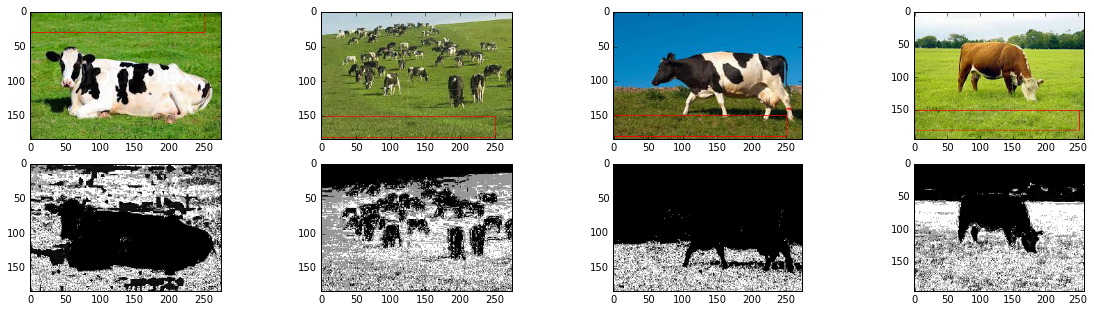

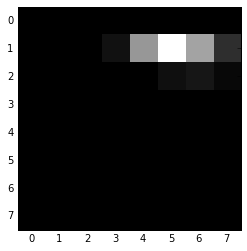

In [12]:
import os
path = "../images"
images = ["cow1.jpg","cow2.jpg","cow3.jpg","cow4.jpg"]
images = [cv2.imread(os.path.join(path,image),cv2.IMREAD_COLOR) for image in images]
rgb = [cv2.cvtColor(image,cv2.COLOR_BGR2RGB) for image in images]
hsv_images = [cv2.cvtColor(image,cv2.COLOR_BGR2HSV) for image in images]
rois = [(0,0,250,30),(0,150,250,180),(0,150,250,180),(0,150,250,180)]

# plot all the images with the regions we selected as containing grass (note they are all the same shape for convinient stacking)
fig,ax = plt.subplots(2,len(images),figsize = (20,5))

# make an hsv image containing all the grass regions we have selected.
grass = np.vstack((image[ymin:ymax,xmin:xmax] for ((xmin,ymin,xmax,ymax),image) in zip(rois,hsv_images) ))
hist = cv2.calcHist([grass],[0,1],mask = None, histSize = [8,8], ranges = [0, 180, 0, 256])
cv2.normalize(hist,hist,0,1,cv2.NORM_MINMAX)

for indx,image in enumerate(rgb):
    hsv = hsv_images[indx]
    xmin,ymin,xmax,ymax = rois[indx]
    cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(255,0,0),1)
    ax[0,indx].imshow(image)
    dst = cv2.calcBackProject([hsv],[0,1],hist,[0, 180, 0, 256],scale=255) 
    ax[1,indx].imshow(dst,cmap="gray")
    
fig,ax = plt.subplots()
ax.imshow(hist,interpolation="nearest",cmap="gray")

Experiment with applying thresholds on the backprojected images to extract the grass region. Some pixels that are part of the grass are marked as having very low probability of being grass (show up dark in the images above. How might we improve finding continuous regions of grass?

## Edges

Edge detection algorithms find regions in the image where the intensity changes quickly (high intensity gradient). 

Canny edge detection takes two parameters 
maxval - the value of gradient above which pixels are considered definately part of an edge
minval - the value of gradient below which pixels are considered not part of an edge
Pixels with gradients between these values are considered edge pixels if the are connected to "definately edge" pixels.

For more details http://docs.opencv.org/3.2.0/da/d22/tutorial_py_canny.html

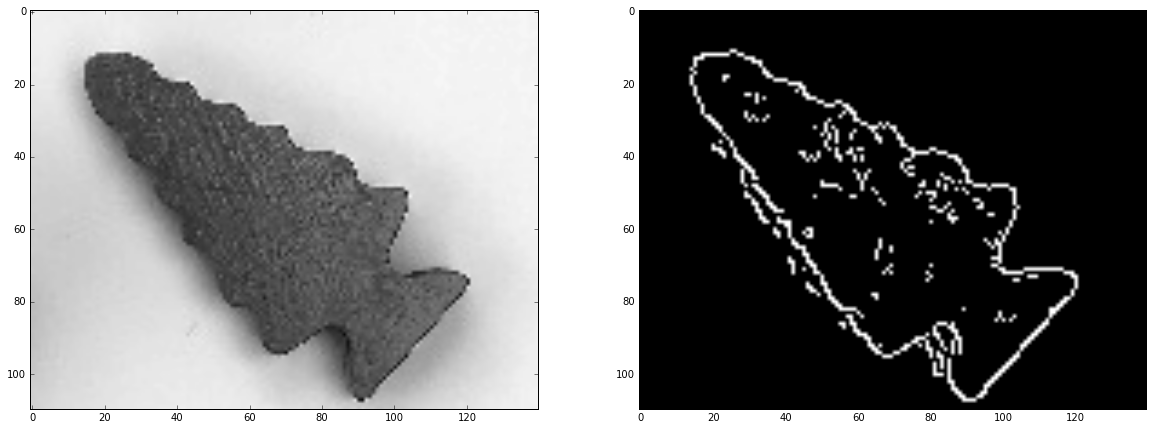

In [15]:
grey = cv2.cvtColor(rgb_images[0],cv2.COLOR_RGB2GRAY)[200:310,230:370]

def find_edges(minval,maxval):
    edges = cv2.Canny(grey,minval,maxval)
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grey,cmap = 'gray')
    ax[1].imshow(edges,cmap = 'gray')
    
find_edges(90,125)

## Template matching
Template matching searches for a small image (template) inside a larger image by sliding the template over the image and comparing the pixel values. The template needs to be very similar to the regions in the image on a pixel wise basis. It is not invariant to scale or rotation.

For more details see

http://docs.opencv.org/3.2.0/d4/dc6/tutorial_py_template_matching.html
http://docs.opencv.org/3.2.0/df/dfb/group__imgproc__object.html


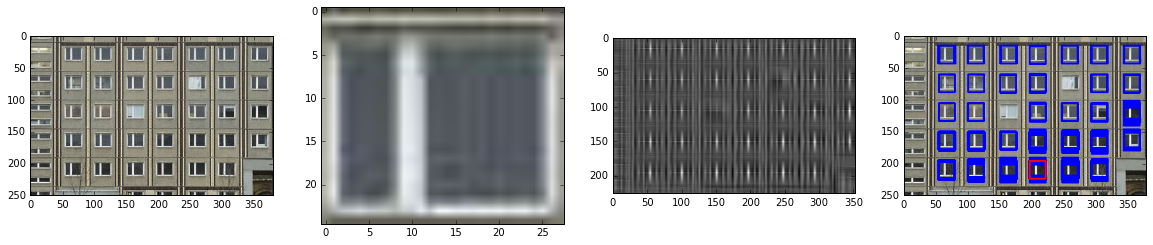

In [13]:
img = cv2.imread("../images/windows.jpg") #[ymin:ymax,xmin:xmax,channels]
rgb_orig = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
rgb = rgb_orig.copy()
template = rgb[16:41,54:82,:].copy()
w,h,_ = template.shape

method = cv2.TM_CCOEFF #'cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
            
res = cv2.matchTemplate(rgb,template,method)
res = cv2.normalize(res, 0, 255, norm_type=cv2.NORM_MINMAX)

# draw a blue rectangle around all the places the template matches (above some threshold)
threshold = 180
matches = np.where(res > threshold)
for top_left in zip(matches[1],matches[0]):
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(rgb,top_left,bottom_right,(0,0,255),2)

# draw a red rectangle around the single best match for the template in the image    
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)   
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(rgb,top_left, bottom_right, 255, 2)

fig,ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(rgb_orig)
ax[1].imshow(template)
ax[2].imshow(res,cmap="gray")
ax[3].imshow(rgb)


Play around with the different methods for template matching. If you look closely at the picture on the right, you will see many of the windows have been found multiple times. Can you think of a way to fix this?


## Feature matching

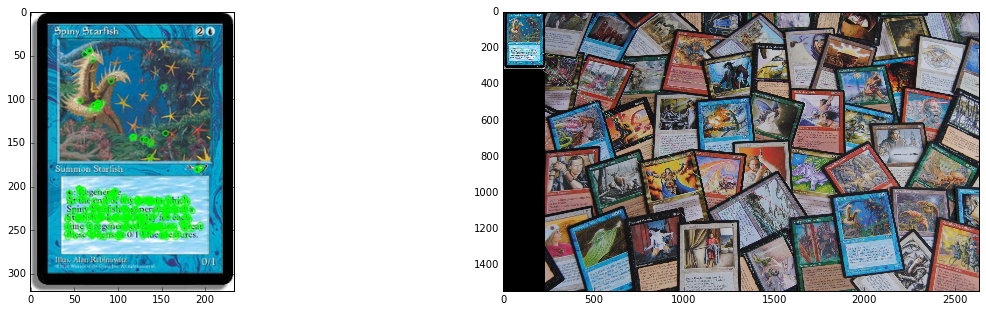

(<matplotlib.image.AxesImage at 0x7f288c5e8490>, None)

In [14]:
img1 = cv2.cvtColor(cv2.imread("../images/spinystarfish_magic.jpg"),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("../images/magic_the_gathering.jpg"),cv2.COLOR_BGR2RGB)

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2,des2 = orb.detectAndCompute(img2,None)

img1_with_keypoints = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(img1_with_keypoints), ax[1].imshow(img2)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=2)
plt.imshow(img3),plt.show()

## Resources
http://docs.opencv.org/3.2.0/d6/d00/tutorial_py_root.html

http://www.learnopencv.com/

http://www.pyimagesearch.com/